#Model comparison and validation for Northern Italy

###Import Python and Obspy modules

In [1]:
# To keep the figure inside the notebook
%matplotlib inline

import glob
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import os
import sys

from obspy import Stream, UTCDateTime, readEvents, read_inventory
from obspy.core import read
from obspy.core.util import locations2degrees
from obspy.imaging.beachball import Beachball
from obspy.taup import TauPyModel

###INPUTS
####Set the following options:
1. event_name
2. forward_modeling

Based on the list created in this cell, go to the next cell and enter desired station ids.

In [2]:
# available events are:
# Global:
# GCMT_2014_04_01__Mw_8_1  GCMT_2014_04_04__Mw_6_2  GCMT_2015_04_25__Mw_7_9  GCMT_2015_05_12__Mw_7_2
# Local:
# INGV_2012_05_29__Mw_5_6  INGV_2015_01_23__Mw_4_3
event_name = 'INGV_2012_05_29__Mw_5_6'

# available methods are:
# specfem3d
forward_modeling = 'specfem3d'

# List all the avaiable stations for the selected event in event_name
add_stations_avail = glob.glob(os.path.join('data', 'waveforms', event_name, '*.sac'))
print "For %s %i stations are available:" % (event_name, len(add_stations_avail))
for add_sta in add_stations_avail:
    print os.path.basename(add_sta)

For INGV_2012_05_29__Mw_5_6 18 stations are available:
IV_BOB_E.sac
IV_BDI_Z.sac
IV_TEOL_E.sac
IV_PRMA_Z.sac
IV_SALO_E.sac
IV_PRMA_N.sac
IV_BOB_N.sac
IV_PESA_N.sac
IV_SALO_N.sac
IV_PESA_E.sac
IV_TEOL_Z.sac
IV_PRMA_E.sac
IV_BDI_N.sac
IV_PESA_Z.sac
IV_BDI_E.sac
IV_TEOL_N.sac
IV_SALO_Z.sac
IV_BOB_Z.sac


###StationsIDs (Choose from the available stations listed above)

In [3]:
# WARNING: since we use the sac headers, make sure that you only select the sac files!
data_ids = ['IV_BDI_Z.sac', 'IV_TEOL_Z.sac', 'IV_TEOL_Z.sac', 'IV_SALO_N.sac', 'IV_TEOL_N.sac']

###Read event information

Event information is provided in the following two formats:
1. QuakeML
2. CMTSOLUTION with the following description:

<img src="./figs/event_info.png">

Here, we use QuakeML to read the event information.

In [4]:
# read event information and crate a dictionary
ev_info = readEvents(os.path.join('data', 'events', 'quakeml', event_name + '.xml'))

ev_info_dict = {}
ev_info_dict['time'] = ev_info[0].preferred_origin().time 
ev_info_dict['lat'] = ev_info[0].preferred_origin().latitude
ev_info_dict['lon'] = ev_info[0].preferred_origin().longitude
ev_info_dict['depth'] = ev_info[0].preferred_origin().depth/1000.
ev_info_dict['mrr'] = ev_info[0].preferred_origin().latitude
moment_tensor = ev_info[0].preferred_focal_mechanism().moment_tensor.tensor
ev_info_dict['mtt'] = moment_tensor['m_rr']
ev_info_dict['mpp'] = moment_tensor['m_pp']
ev_info_dict['mrt'] = moment_tensor['m_rt']
ev_info_dict['mrp'] = moment_tensor['m_rp']
ev_info_dict['mtp'] = moment_tensor['m_tp']

###Beachball for the selected event

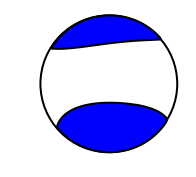

In [5]:
# Graphical representation of the focal mechanism:
focmecs = [ev_info_dict['mrr'], ev_info_dict['mtt'], ev_info_dict['mpp'], 
           ev_info_dict['mrt'], ev_info_dict['mrp'], ev_info_dict['mtp']]
Beachball(focmecs, size=200, linewidth=2, facecolor='b')
plt.show()

###Read station information

In [6]:
# read the information of all stations. In the next steps, we will extract data from sta_info_xml.
sta_info_xml = read_inventory(os.path.join('data', 'stations', 'all_stations.xml'))

###Read real and synthetic waveforms

In [7]:
# Define empty streams and append the traces in the next step.
real_wfs = Stream()
syn_wfs = Stream()
for data_id in data_ids:
    real_wfs.append(read(os.path.join('data', 'waveforms', event_name, data_id))[0])

# read synthetic waveforms:
# 1. read all the waveforms.
syn_wfs_all = read(os.path.join('data', forward_modeling, '*.sac'))

# only a flag to print the warning message
print_debug = False
for real_wf in real_wfs:
    # 2. select the synthetic waveform based on real data IDs
    sel_tr = syn_wfs_all.select(network=real_wf.stats.network,
                                station=real_wf.stats.station,
                                location=real_wf.stats.location,
                                channel=real_wf.stats.channel)
    # 3. if the data is available, append it to syn_wfs
    if len(sel_tr) > 0:
        syn_wfs.append(syn_wfs_all.select(network=real_wf.stats.network,
                                          station=real_wf.stats.station,
                                          location=real_wf.stats.location,
                                          channel=real_wf.stats.channel)[0])
    # ELSE: remove it from the real data!
    # in this step, we make sure that #real waveforms = #synthetic waveforms
    else:
        print "Have you simulated %s.%s.%s.%s?" % (real_wf.stats.network, real_wf.stats.station,
                                                   real_wf.stats.location, real_wf.stats.channel)
        print_debug = True
        real_wfs.remove(real_wf)

# if program can not find synthetic waveforms for all real data, print a warning message
if print_debug:
    print "\n---------------------------------------------------------"
    print "WARNING: above station(s) are removed from the real data."
    print "\nSolutions:"
    print "1. simulate desired waveforms."
    print "2. make sure that network, station, location and channel are set correctly in the header."

Have you simulated IV.SALO..BHN?
Have you simulated IV.TEOL..BHN?

---------------------------------------------------------

Solutions:
1. simulate desired waveforms.
2. make sure that network, station, location and channel are set correctly in the header.


###Event and station(s) projected on a map

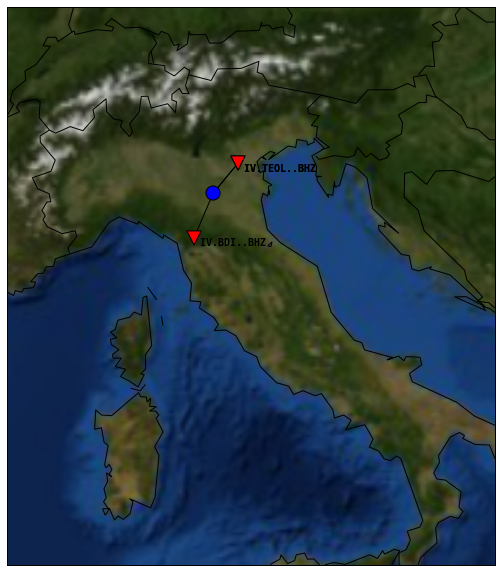

In [8]:
# extract latitude(s), longitude(s) and name(s) of all stations:
sta_lats = []
sta_lons = []
sta_names = []
for real_wf in real_wfs:
    sta_info = '%s.%s.%s.%s' % (real_wf.stats.network, real_wf.stats.station, 
                                real_wf.stats.location, real_wf.stats.channel)
    sta_lats.append(sta_info_xml.get_coordinates(sta_info)['latitude'])
    sta_lons.append(sta_info_xml.get_coordinates(sta_info)['longitude'])
    sta_names.append(sta_info)

plt.figure(figsize=(20, 10))
m = Basemap(projection='merc', resolution="l",
            llcrnrlon=6, llcrnrlat=38, 
            urcrnrlon=18, urcrnrlat=48)
m.drawcountries(color="black", linewidth=1)
m.drawcoastlines()
m.bluemarble()

x, y = m(sta_lons, sta_lats)
# plot all the stations:
m.scatter(x, y, 200, color="r", marker="v", edgecolor="k", zorder=3)
# assign a name to each station:
for i in range(len(sta_names)):
    plt.text(x[i], y[i], ' ' + sta_names[i], va="top", family="monospace", weight="bold")
    m.drawgreatcircle(ev_info_dict['lon'], ev_info_dict['lat'], sta_lons[i], sta_lats[i], color='k')

# plot the event:
x_ev, y_ev = m(ev_info_dict['lon'], ev_info_dict['lat'])
m.scatter(x_ev, y_ev, 200, color="b", marker="o", edgecolor="k", zorder=3)

# ax = plt.gca()
# x_ev, y_ev = m(ev_info_dict['lon'], ev_info_dict['lat'])
# b = Beachball(focmecs, xy=(x_ev, y_ev), width=100, linewidth=1)
# ax.add_collection(b)

plt.show()

###Resample real and synthetic waveforms
####since the sampling rate of real and synthetic wavefomrs can be different, in this step, we make sure that all the traces have similar sampling rate.

In [9]:
# find the minimum sampling rate:
min_sampling = real_wfs[0].stats.sampling_rate
for i in range(len(real_wfs)):
    min_sampling = min(min_sampling, real_wfs[i].stats.sampling_rate, syn_wfs[i].stats.sampling_rate)

# resample
real_wfs.resample(min_sampling)
syn_wfs.resample(min_sampling)

# collect the starttime of synthetic waveforms, this list will be used in the next cell.
syn_initial_starttime = []
for syn_wf in syn_wfs:
    syn_initial_starttime.append(syn_wf.stats.starttime)

###Set start time of the synthetics

In [10]:
for i, syn_wf in enumerate(syn_wfs):
    syn_starttime = ev_info_dict['time'] + (UTCDateTime(0) - syn_initial_starttime[i])
    syn_wf.stats.starttime = syn_starttime
print 'Synthetic waveforms:'
print syn_wfs
print '==================='
print 'Real waveforms:'
print real_wfs

Synthetic waveforms:
3 Trace(s) in Stream:
IV.BDI..BHZ  | 2012-05-29T07:00:02.930000Z - 2012-05-29T07:08:22.830000Z | 20.0 Hz, 9999 samples
IV.TEOL..BHZ | 2012-05-29T07:00:02.930000Z - 2012-05-29T07:08:22.830000Z | 20.0 Hz, 9999 samples
IV.TEOL..BHZ | 2012-05-29T07:00:02.930000Z - 2012-05-29T07:08:22.830000Z | 20.0 Hz, 9999 samples
Real waveforms:
3 Trace(s) in Stream:
IV.BDI..BHZ  | 2012-05-29T06:55:39.845000Z - 2012-05-29T08:30:13.145000Z | 20.0 Hz, 113467 samples
IV.TEOL..BHZ | 2012-05-29T06:55:39.195000Z - 2012-05-29T08:30:12.595000Z | 20.0 Hz, 113469 samples
IV.TEOL..BHZ | 2012-05-29T06:55:39.195000Z - 2012-05-29T08:30:12.595000Z | 20.0 Hz, 113469 samples


###Slice both synthetic and real data

In [11]:
# Find the latest starttime and the earliest endtime among all stations
slice_starttime = syn_wfs[0].stats.starttime
slice_endtime = syn_wfs[0].stats.endtime
for i in range(len(real_wfs)):
    slice_starttime = max(slice_starttime, real_wfs[i].stats.starttime, syn_wfs[i].stats.starttime)
    slice_endtime = min(slice_endtime, real_wfs[i].stats.endtime, syn_wfs[i].stats.endtime)
    
real_wfs = real_wfs.slice(starttime=slice_starttime, endtime=slice_endtime)
syn_wfs = syn_wfs.slice(starttime=slice_starttime, endtime=slice_endtime) 

print 'Synthetic waveforms:'
print syn_wfs
print '==================='
print 'Real waveforms:'
print real_wfs

Synthetic waveforms:
3 Trace(s) in Stream:
IV.BDI..BHZ  | 2012-05-29T07:00:02.930000Z - 2012-05-29T07:08:22.830000Z | 20.0 Hz, 9999 samples
IV.TEOL..BHZ | 2012-05-29T07:00:02.930000Z - 2012-05-29T07:08:22.830000Z | 20.0 Hz, 9999 samples
IV.TEOL..BHZ | 2012-05-29T07:00:02.930000Z - 2012-05-29T07:08:22.830000Z | 20.0 Hz, 9999 samples
Real waveforms:
3 Trace(s) in Stream:
IV.BDI..BHZ  | 2012-05-29T07:00:02.945000Z - 2012-05-29T07:08:22.845000Z | 20.0 Hz, 9999 samples
IV.TEOL..BHZ | 2012-05-29T07:00:02.945000Z - 2012-05-29T07:08:22.845000Z | 20.0 Hz, 9999 samples
IV.TEOL..BHZ | 2012-05-29T07:00:02.945000Z - 2012-05-29T07:08:22.845000Z | 20.0 Hz, 9999 samples


###Process the data here

In [12]:
# Make a copy of the resampled data (this avoids running the above cells)
real_wfs_cp = real_wfs.copy()
syn_wfs_cp = syn_wfs.copy()

# minimum and maximum frequency
freqmin = 1.0 / 25.0
freqmax = 1.0 / 3.0

real_wfs_cp.detrend("linear")
real_wfs_cp.taper(max_percentage=0.05, type="hann")
real_wfs_cp.filter("bandpass", freqmin=freqmin, freqmax=freqmax, zerophase=True)

syn_wfs_cp.detrend("linear")
syn_wfs_cp.taper(max_percentage=0.05, type="hann")
syn_wfs_cp.filter("bandpass", freqmin=freqmin, freqmax=freqmax, zerophase=True)

3 Trace(s) in Stream:
IV.BDI..BHZ  | 2012-05-29T07:00:02.930000Z - 2012-05-29T07:08:22.830000Z | 20.0 Hz, 9999 samples
IV.TEOL..BHZ | 2012-05-29T07:00:02.930000Z - 2012-05-29T07:08:22.830000Z | 20.0 Hz, 9999 samples
IV.TEOL..BHZ | 2012-05-29T07:00:02.930000Z - 2012-05-29T07:08:22.830000Z | 20.0 Hz, 9999 samples

###Define a function to plot the waveforms

In [13]:
# Here, we define a function to plot real and synthetic waveforms
# This function will be used in the following cells.
def plot_real_syn(real_wfs, syn_wfs, plt_xlim=False, cal_arrivals=False):
    """
    Function to plot real and synthetic waveforms
    """
    # in case that the arrivals should be plotted, initialize the TauPy model
    if cal_arrivals:
        model = TauPyModel(model="iasp91")
        
    plt.figure(figsize=(len(real_wfs)*7, 10))
    for i, real_wf in enumerate(real_wfs):
        sta_info = '%s.%s.%s.%s' % (real_wf.stats.network, real_wf.stats.station, 
                                    real_wf.stats.location, real_wf.stats.channel)
        # calculate the epicentral distance
        dist = locations2degrees(ev_info_dict['lat'], ev_info_dict['lon'], 
                                 sta_info_xml.get_coordinates(sta_info)['latitude'],
                                 sta_info_xml.get_coordinates(sta_info)['longitude'])
        
        if cal_arrivals:
            # Arrival times of all seismic phases!
            arrivals = model.get_travel_times(source_depth_in_km=ev_info_dict['depth'], distance_in_degree=dist)
        
        # Subplots in the left: with normalized amplitude
        plt.subplot(len(real_wfs)*2, 2, 2*i+1)
        # time axis of the real data
        tax_real = np.linspace(0, (real_wf.stats.npts - 1)/real_wf.stats.sampling_rate, real_wf.stats.npts)
        plt.plot(tax_real, real_wf.data/max(abs(real_wf.data)), c='k', label='real')
        
        # to plot the synthetic data, the time axis should be adjusted:
        time_difference = syn_wfs[i].stats.starttime - real_wf.stats.starttime
        # time axis of the synthetic data
        tax_syn = time_difference + np.linspace(0, (syn_wfs[i].stats.npts - 1)/syn_wfs[i].stats.sampling_rate, syn_wfs[i].stats.npts)
        plt.plot(tax_syn, syn_wfs[i].data/max(abs(syn_wfs[i].data)), c='r', label='synthetic')
        
        # To avoid adding label to all figures: 
        if i == 0:
            plt.ylabel('Normalized amplitude', size=18, weight='bold')
        if i == (len(real_wfs) - 1):
            plt.xlabel('Time', size=18, weight='bold')
        plt.title('%s.%s' % (real_wf.stats.network, real_wf.stats.station))
        
        # If the arrival times should be added to the plot:
        if cal_arrivals:
            for arr in arrivals:
                if not arr.time > tax_syn[-1]:
                    plt.axvline(arr.time, 0, 1, 'k')
        if plt_xlim:
            plt.xlim(0, plt_xlim)

        # Subplots in the right: with true amplitude
        plt.subplot(len(real_wfs)*2, 2, 2*i+2)
        # time axis of the real data
        tax_real = np.linspace(0, (real_wf.stats.npts - 1)/real_wf.stats.sampling_rate, real_wf.stats.npts)
        plt.plot(tax_real, real_wf.data/1.e9, c='k', label='real')
        
        # to plot the synthetic data, the time axis should be adjusted:
        time_difference = syn_wfs[i].stats.starttime - real_wf.stats.starttime
        # time axis of the synthetic data
        tax_syn = time_difference + np.linspace(0, (syn_wfs[i].stats.npts - 1)/syn_wfs[i].stats.sampling_rate, syn_wfs[i].stats.npts)
        plt.plot(tax_syn, syn_wfs[i].data, c='r', label='synthetic')
        
        # To avoid adding label to all figures: 
        if i == 0:
            plt.ylabel('Amplitude', size=18, weight='bold')
        if i == (len(real_wfs) - 1):
            plt.xlabel('Time', size=18, weight='bold')
        plt.title('%s.%s' % (real_wf.stats.network, real_wf.stats.station))
        
        # If the arrival times should be added to the plot:
        if cal_arrivals:
            print "list of phases: (station: %s.%s, dist: %s)" % (real_wf.stats.network, real_wf.stats.station, dist)
            for arr in arrivals:
                if not arr.time > tax_syn[-1]:
                    plt.axvline(arr.time, 0, 1, 'k')
                    print '%s' % (arr.name),
            print "\n"
        if plt_xlim:
            plt.xlim(0, plt_xlim)
            
        plt.legend()

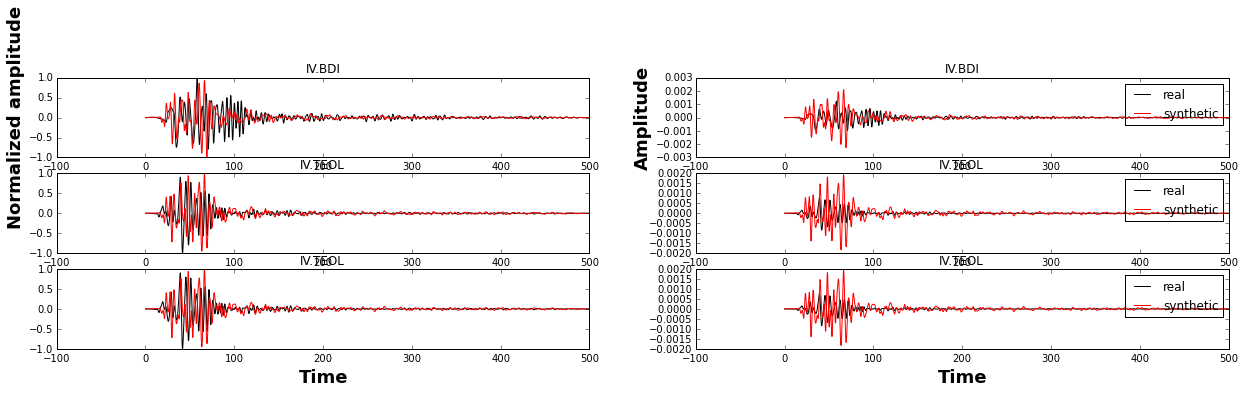

In [14]:
# use the function defined in the previous step:
plot_real_syn(real_wfs=real_wfs_cp, syn_wfs=syn_wfs_cp)

list of phases: (station: IV.BDI, dist: 0.848105458673)
p P P P Pn sP P sP sP pP pP sP sP s S S S Sn S 

list of phases: (station: IV.TEOL, dist: 0.674277541291)
p P P sP P Pn P s S S 

list of phases: (station: IV.TEOL, dist: 0.674277541291)
p P P sP P Pn P s S S 



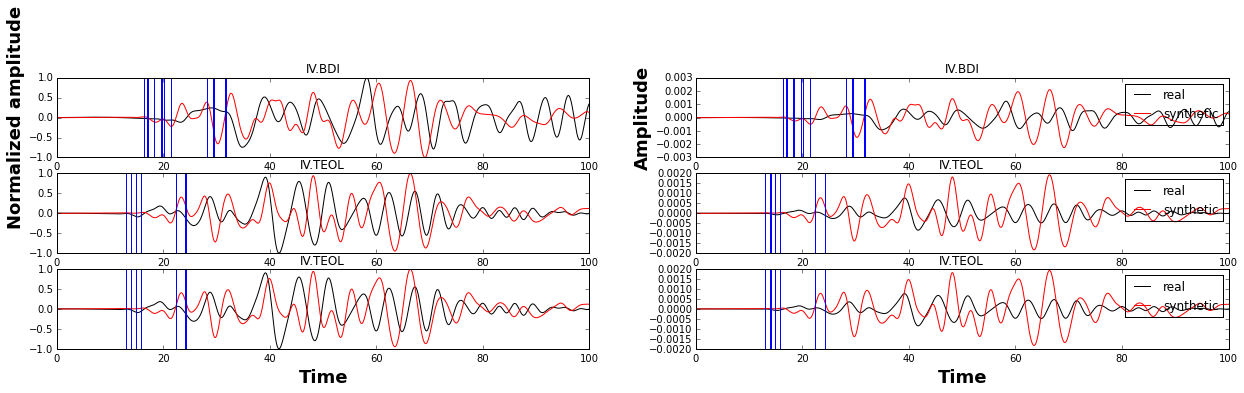

In [15]:
# Zoom in to the above figures and add the arrival times:
plot_real_syn(real_wfs=real_wfs_cp, syn_wfs=syn_wfs_cp, plt_xlim=100, cal_arrivals=True)

###Calculate PGD/PGV/PGA

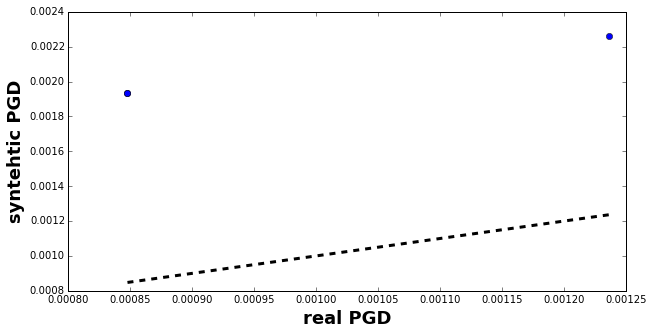

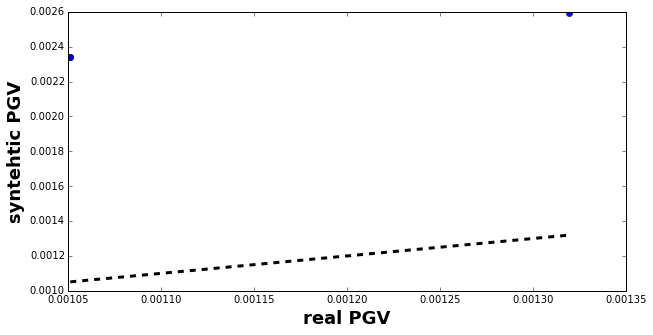

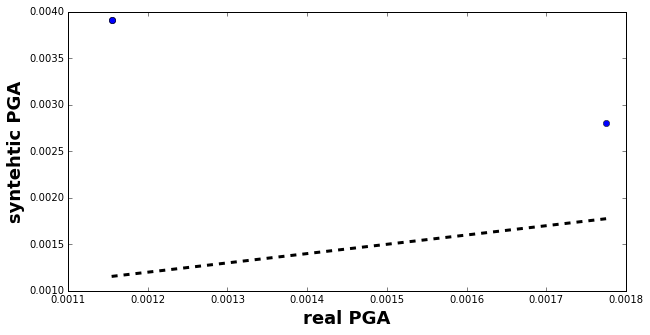

In [16]:
# make a copy of the waveforms
syn_wfs_pgd = syn_wfs_cp.copy()
real_wfs_pgd = real_wfs_cp.copy()

# ================= Calculate PGD
pgd_syn = syn_wfs_pgd.max()
pgd_real = real_wfs_pgd.max()

plt.figure(figsize=(10, 5))
plt.plot(np.abs(pgd_real)/1.e9, np.abs(pgd_syn), 'o')
plt.plot([min(np.abs(pgd_real))/1.e9, max(np.abs(pgd_real))/1.e9], 
         [min(np.abs(pgd_real))/1.e9, max(np.abs(pgd_real))/1.e9], 
         'k--', lw=3)
plt.xlabel('real PGD', size=18, weight='bold')
plt.ylabel('syntehtic PGD', size=18, weight='bold')
plt.show()

# ================= Calculate PGV
pgv_syn = syn_wfs_pgd.differentiate().max()
pgv_real = real_wfs_pgd.differentiate().max()

plt.figure(figsize=(10, 5))
plt.plot(np.abs(pgv_real)/1.e9, np.abs(pgv_syn), 'o')
plt.plot([min(np.abs(pgv_real))/1.e9, max(np.abs(pgv_real))/1.e9], 
         [min(np.abs(pgv_real))/1.e9, max(np.abs(pgv_real))/1.e9], 
         'k--', lw=3)
plt.xlabel('real PGV', size=18, weight='bold')
plt.ylabel('syntehtic PGV', size=18, weight='bold')
plt.show()

# ================= Calculate PGA
pga_syn = syn_wfs_pgd.differentiate().max()
pga_real = real_wfs_pgd.differentiate().max()

plt.figure(figsize=(10, 5))
plt.plot(np.abs(pga_real)/1.e9, np.abs(pga_syn), 'o')
plt.plot([min(np.abs(pga_real))/1.e9, max(np.abs(pga_real))/1.e9], 
         [min(np.abs(pga_real))/1.e9, max(np.abs(pga_real))/1.e9], 
         'k--', lw=3)
plt.xlabel('real PGA', size=18, weight='bold')
plt.ylabel('syntehtic PGA', size=18, weight='bold')
plt.show()

In [99]:
#################### TRASH #########################
import pyflex

config = pyflex.Config(
    min_period=50.0, max_period=150.0,
    stalta_waterlevel=0.08, tshift_acceptance_level=15.0,
    dlna_acceptance_level=1.0, cc_acceptance_level=0.80,
    c_0=0.7, c_1=4.0, c_2=0.0, c_3a=1.0, c_3b=2.0, c_4a=3.0, c_4b=10.0)

print wf_spec3.stats.npts
print wf_data.stats.npts



windows = pyflex.select_windows(wf_data, wf_spec3, config, plot=True)

NameError: name 'wf_spec3' is not defined